In [156]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import random

In [157]:
# check extraction tables

table_2012 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2012.parquet')
table_2013 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2013.parquet')
table_2014 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2014.parquet')
table_2015 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2015.parquet')
table_2016 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2016.parquet')
table_2017 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2017.parquet')
table_2018 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2018.parquet')
table_2019 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2019.parquet')
table_2020 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2020.parquet')

table_all = pandas.concat([table_2012, table_2013, table_2014, table_2015,
                        table_2016, table_2017, table_2018, table_2019, table_2020])
table_all.reset_index(drop=True, inplace=True)

In [158]:
table_all = table_all.dropna(subset=['LL']) # now we have the matching L2 and L3S w/o days that were skipped

In [159]:
# hypothesis 1: L3S smoothed out fields, this would result in lower DT and high LL
# BUT did it smooth it in a good way (reduce clouds) or did it remove features
# ways to test: in areas that we know should be clear, visually look for temp changes

# mediterranean

med = table_all[
    (table_all['lon'] >= 5) & (table_all['lat'] <= 40) &
    (table_all['lat'] >= 30) & (table_all['lat'] <= 40)
]

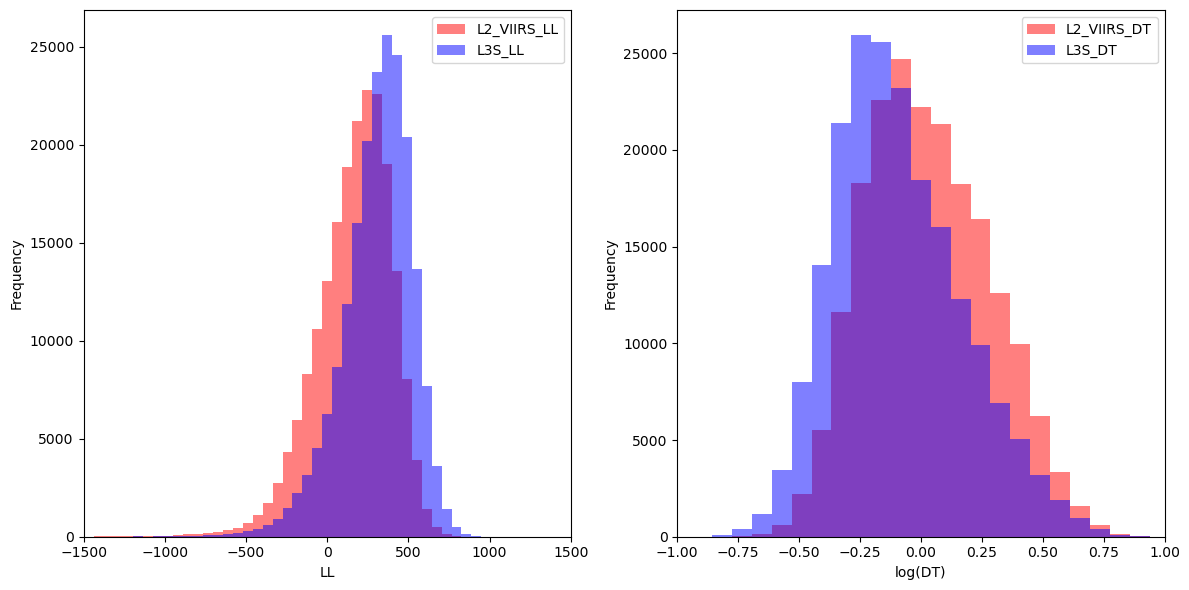

In [160]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bin_edges = np.linspace(-1500, 1500, 50)
plt.hist(med['VIIRS_LL'], bins=bin_edges, alpha=0.5, label='L2_VIIRS_LL', color='red')
plt.hist(med['LL'], bins=bin_edges, alpha=0.5, label = 'L3S_LL', color = 'blue')
plt.xlabel('LL')
plt.ylabel('Frequency')
plt.xlim(-1500, 1500)
plt.legend()

plt.subplot(1, 2, 2)
bin_edges = np.linspace(-2,2, 50)
plt.hist(np.log10(med['VIIRS_DT']), bins=bin_edges, alpha=0.5, label='L2_VIIRS_DT', color='red')
plt.hist(np.log10(med['DT']), bins=bin_edges, alpha=0.5, label='L3S_DT', color='blue')
plt.xlabel('log(DT)')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()

plt.tight_layout()
plt.show()
# so even in this area that should be really clear to begin with, the L3S data is still increasing LL and decreasing DT

In [161]:
middle_atlantic = table_all[
    (table_all['lon'] >= -45) & (table_all['lon'] <= -25) &
    (table_all['lat'] >= 30) & (table_all['lat'] <= 40)
]

In [162]:
middle_atlantic.loc[:,'VIIRS_clear_fraction'] = 1 - middle_atlantic.loc[:,'VIIRS_clear_fraction']
diff = middle_atlantic.loc[:,'clear_fraction'] - middle_atlantic.loc[:,'VIIRS_clear_fraction']
middle_atlantic.loc[:,'clear_frac_diff'] = diff

med.loc[:,'VIIRS_clear_fraction'] = 1 - med.loc[:,'VIIRS_clear_fraction']
diff = med.loc[:,'clear_fraction'] - med.loc[:,'VIIRS_clear_fraction']
med.loc[:,'clear_frac_diff'] = diff

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_37170/1978808342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_atlantic.loc[:,'clear_frac_diff'] = diff
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_37170/1978808342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med.loc[:,'clear_frac_diff'] = diff


/Users/rachelstumpf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rachelstumpf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


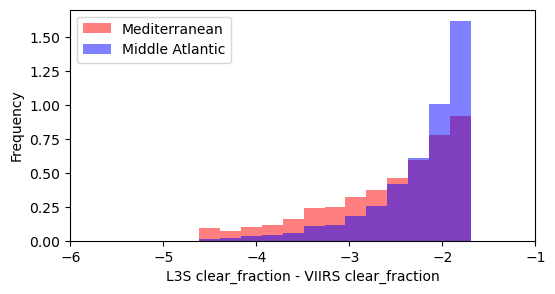

In [163]:
plt.figure(figsize=(6, 3))

bin_edges = np.linspace(-10, 1, 50)
plt.hist(np.log10(med['clear_frac_diff']), bins=bin_edges, alpha=0.5, label='Mediterranean', color='red', density = True)
plt.hist(np.log10(middle_atlantic['clear_frac_diff']), bins=bin_edges, alpha=0.5, label = 'Middle Atlantic', color = 'blue', density = True)
plt.xlabel('L3S clear_fraction - VIIRS clear_fraction')
plt.ylabel('Frequency')
plt.xlim(-6, -1)
plt.legend()

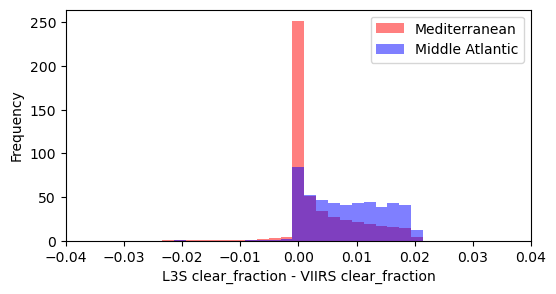

In [164]:
plt.figure(figsize=(6, 3))

bin_edges = np.linspace(-0.05, 0.05, 50)
plt.hist(med['clear_frac_diff'], bins=bin_edges, alpha=0.5, label='Mediterranean', color='red', density = True)
plt.hist(middle_atlantic['clear_frac_diff'], bins=bin_edges, alpha=0.5, label = 'Middle Atlantic', color = 'blue', density = True)
plt.xlabel('L3S clear_fraction - VIIRS clear_fraction')
plt.ylabel('Frequency')
plt.xlim(-0.04, 0.04)
plt.legend()

# clear fractions are usually positive (L3S is more clear)
# Mediterranean is more likely to have exactly the same clear fraction for VIIRS and L3S (likely 1, is completely clear)
# I guess this doesn't tell us about clouds, look at that visually

In [165]:
med_similarDT = med[
    (med['DT'] >= -0.2) & (med['DT'] <= 0.2)
]

In [166]:
random_rows_indices = random.sample(range(len(med_similarDT)), 10)
random_rows = med_similarDT.iloc[random_rows_indices]

In [167]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(None, None), show=False, set_aspect=None, clbl=None,
               ax=None, title=None):
    if cm is None:
        _, cm = plotting.load_palette()
    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})  # 'fontsize': 20})
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    return ax

In [187]:
def plot_cutout_set(data):
    length = len(data)
    fig, axes = plt.subplots(len(data), 2, figsize=(10, 2.5*length))

    for i, (_, row) in enumerate(data.iterrows()):
        pp_file = row['VIIRS_pp_file']
        pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        viirs_year = viirs_datetime.year
        local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        viirs = image_utils.grab_image(matching_row, local_file=local_file)
        viirs = viirs[0, ...]
    
        pp_file = row['pp_file']
        pp_idx = row['pp_idx']
        local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        l3s = image_utils.grab_image(matching_row, local_file=local_file)
        l3s = l3s[0, ...]

        viirs_min = np.min(viirs)
        viirs_max = np.max(viirs)
        l3s_min = np.min(l3s)
        l3s_max = np.max(l3s)

        vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))

        show_image(viirs, ax=axes[i, 0], title=f'VIIRS - Row {i+1}', vmnx=vmnx)
        show_image(l3s, ax=axes[i, 1], title=f'L3S - Row {i+1}', vmnx=vmnx)

    plt.tight_layout()

    plt.show()

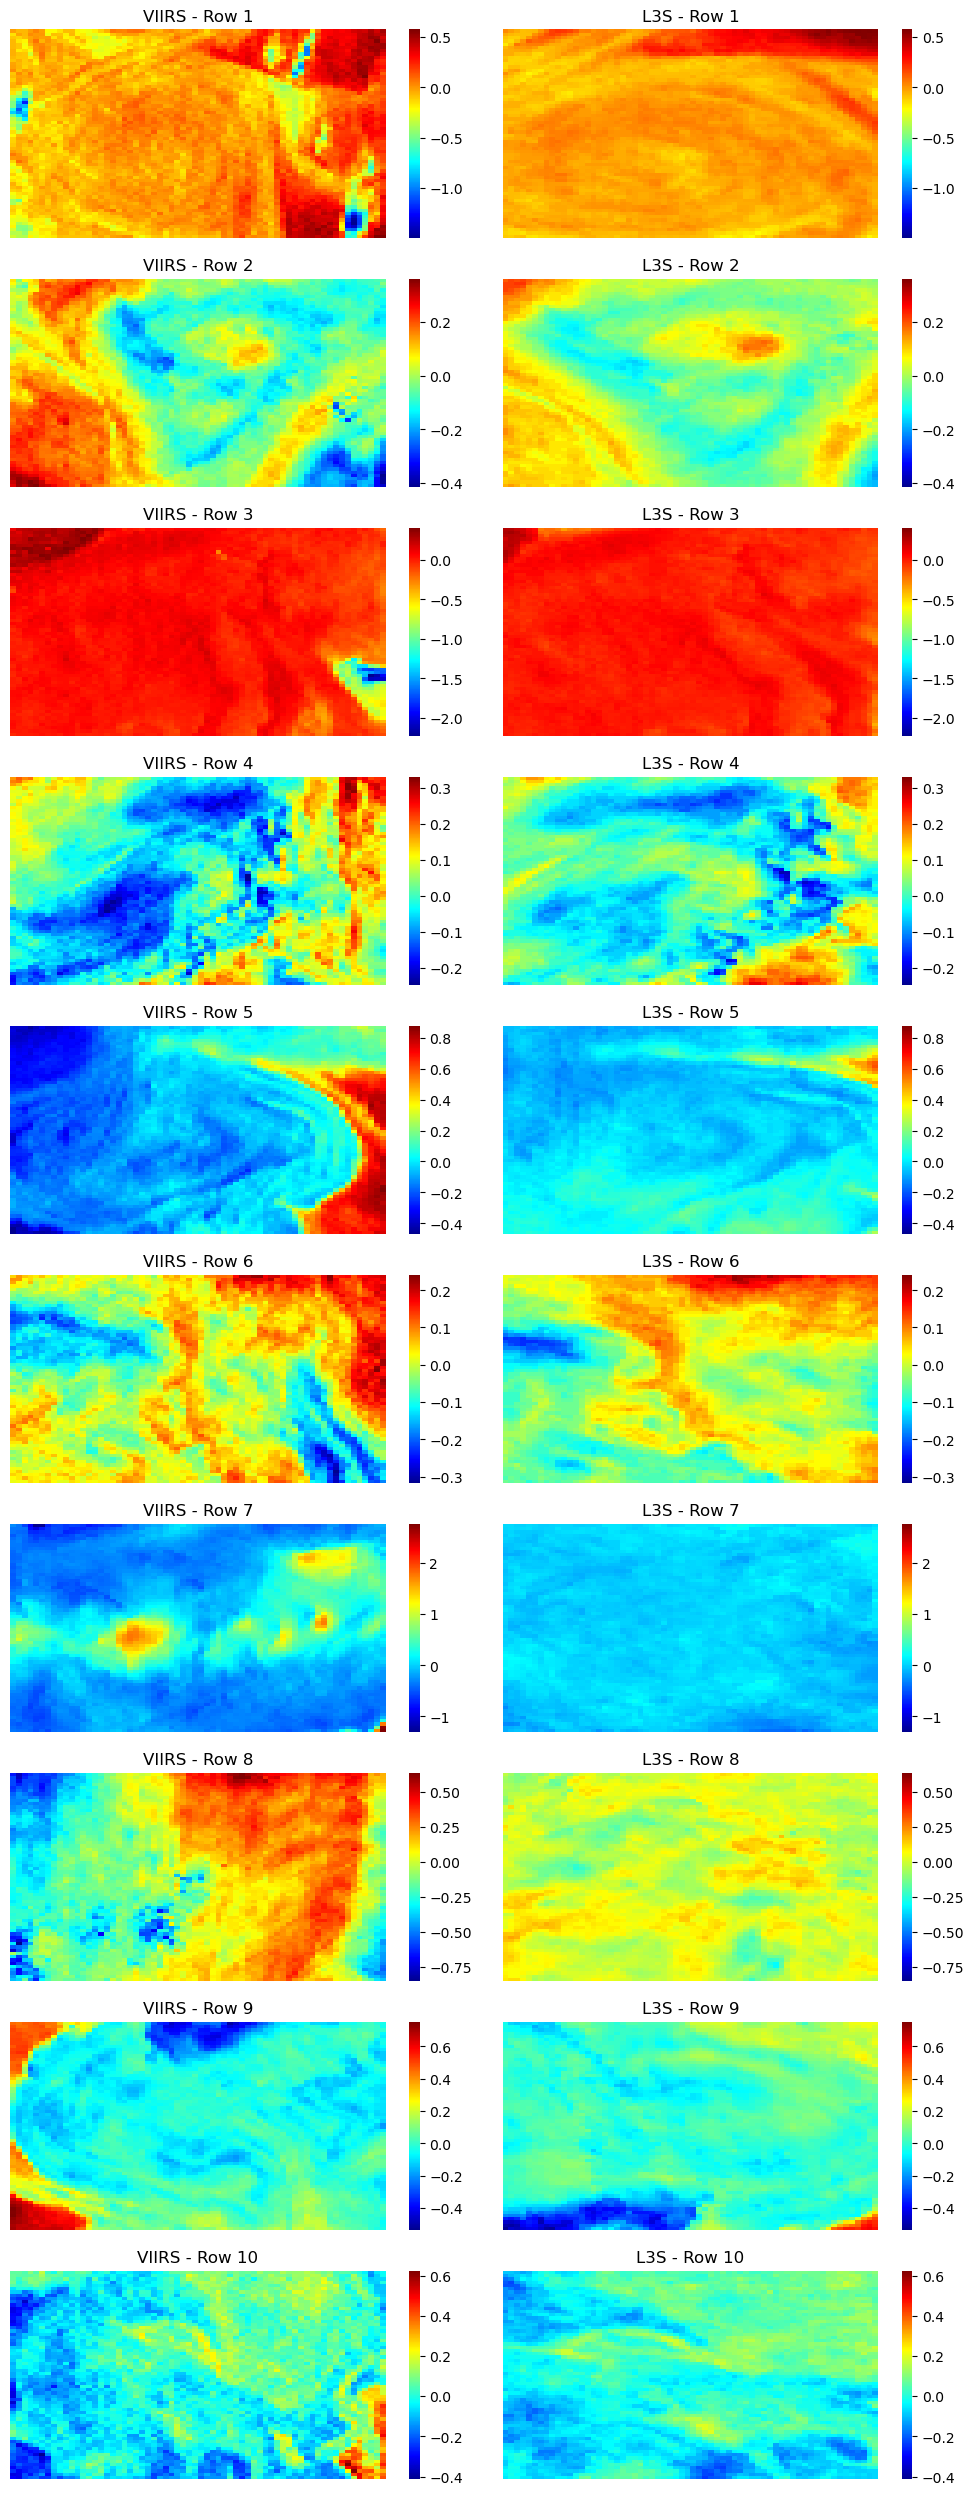

In [188]:
plot_cutout_set(random_rows)

In [ ]:
# hypothesis 2: L2 is already contaminated with clouds
# L3S did well at reducing this then
# ways to test: 

In [171]:
table_all.loc[:,'diff_DT'] = table_all.loc[:,"VIIRS_DT"] - table_all.loc[:,'DT']
table_all.loc[:,'diff_LL'] = table_all.loc[:,"VIIRS_LL"] - table_all.loc[:,'LL']

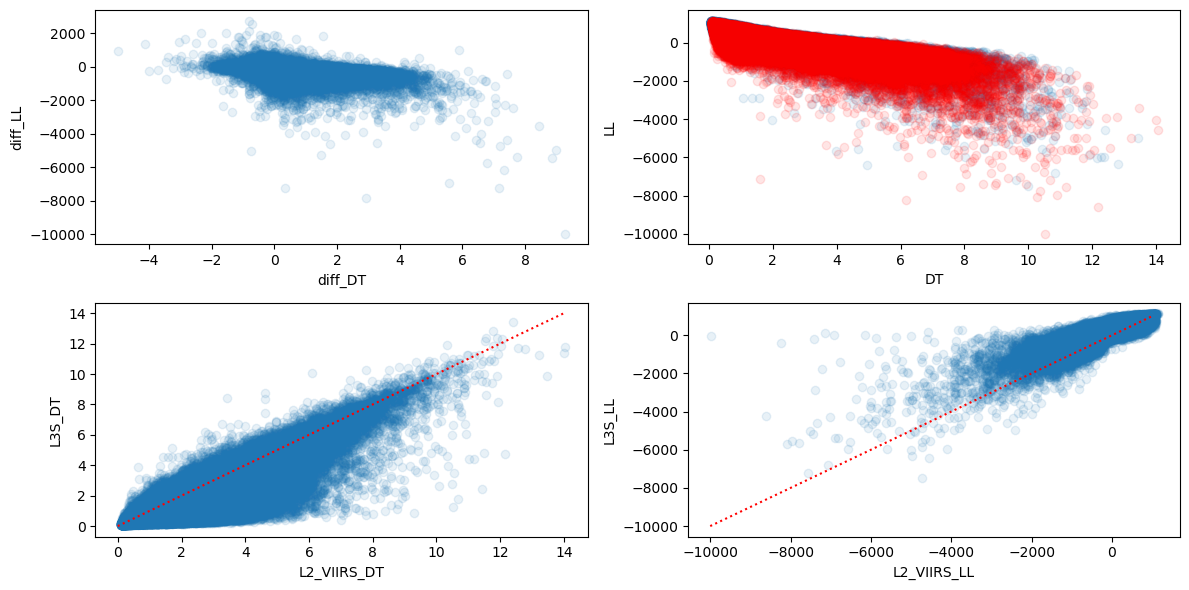

In [172]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(table_all['diff_DT'], table_all['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(table_all['DT'], table_all['LL'], alpha = 0.1) # x,y
plt.scatter(table_all['VIIRS_DT'], table_all['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(table_all['VIIRS_DT'], table_all['DT'], alpha = 0.1) # x,y
plt.plot([0, 14], [0, 14], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(table_all['VIIRS_LL'], table_all['LL'], alpha = 0.1) # x,y
plt.plot([-10000, 1000], [-10000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [173]:
blacksea = table_all[
    (table_all['lat'] >= 43) & (table_all['lat'] <= 44) &
    (table_all['lon'] >= 33) & (table_all['lon'] <= 34)
]

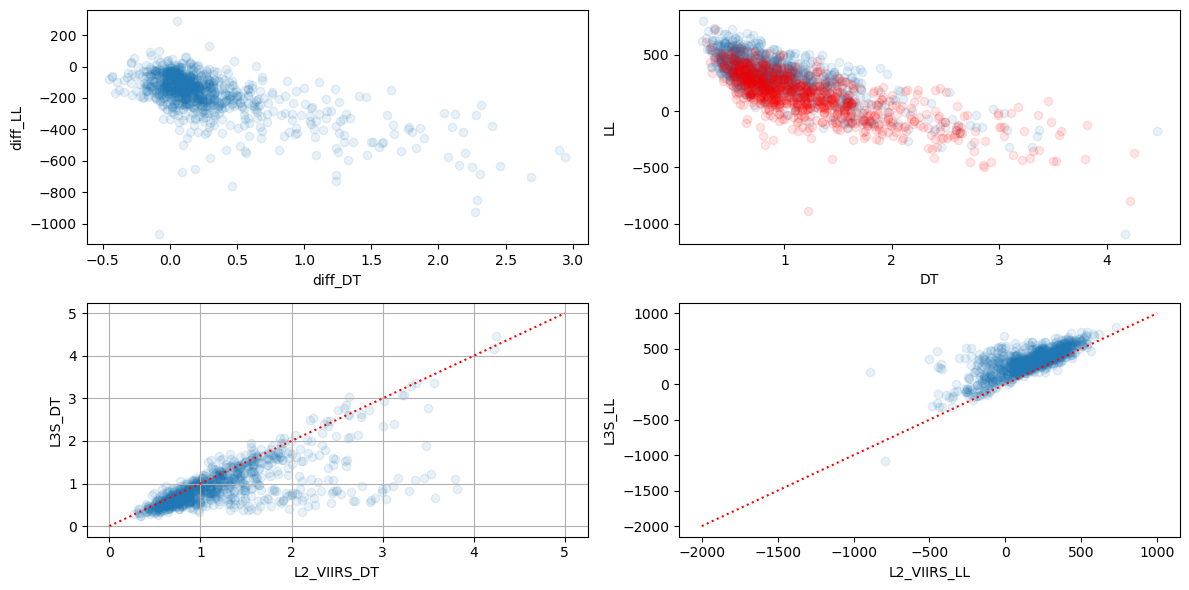

In [174]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(blacksea['diff_DT'], blacksea['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(blacksea['DT'], blacksea['LL'], alpha = 0.1) # x,y
plt.scatter(blacksea['VIIRS_DT'], blacksea['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(blacksea['VIIRS_DT'], blacksea['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(blacksea['VIIRS_LL'], blacksea['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [175]:
new_blacksea = blacksea[
    (blacksea['VIIRS_DT'] >= 1.5) & (blacksea['VIIRS_DT'] <= 2)  &
    (blacksea['DT'] >= 0.5) & (blacksea['DT'] <= 0.6)
]

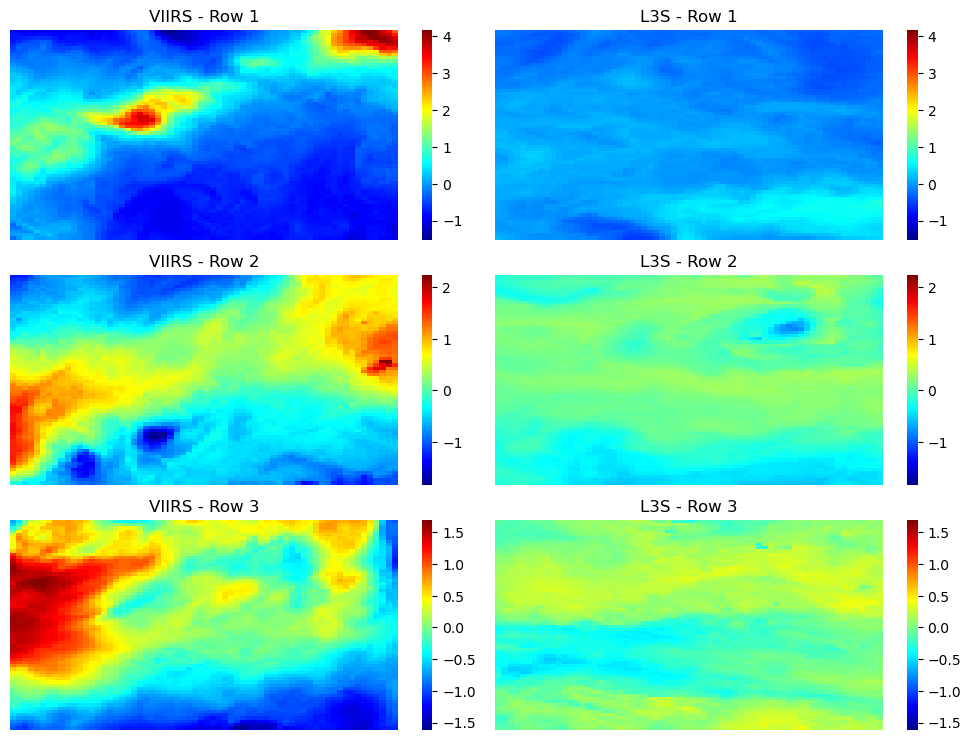

In [189]:
plot_cutout_set(new_blacksea)

In [191]:
table_all.loc[:,'local_timedelta'] = pandas.to_timedelta(table_all.loc[:,'lon'] / 15, unit='H')
table_all.loc[:,'local_suntime'] = table_all.loc[:,'VIIRS_datetime'] + table_all.loc[:,'local_timedelta']
normalized_date = table_all.loc[:,'local_suntime'].dt.normalize()
time_component_timedelta = pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.hour, unit='h') + pandas.to_timedelta(table_all['local_suntime'].dt.minute, unit='m') + pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.second, unit='s')

table_all.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta

In [192]:
table_all[['VIIRS_datetime', 'L2_local_suntime', 'lon']]

,VIIRS_datetime,L2_local_suntime,lon
0,2012-02-01 00:10:00,2012-01-31 12:22:25,-176.892460
1,2012-02-01 00:10:00,2012-01-31 12:24:46,-176.305300
2,2012-02-01 00:10:00,2012-01-31 12:29:19,-175.170240
3,2012-02-01 00:10:00,2012-01-31 12:26:47,-175.801420
4,2012-02-01 00:10:00,2012-01-31 12:23:59,-176.500980
...,...,...,...
2932447,2020-12-31 22:50:00,2020-12-31 13:18:21,-142.909970
2932448,2020-12-31 22:50:00,2020-12-31 12:53:53,-149.027340
2932449,2020-12-31 22:50:00,2020-12-31 12:53:21,-149.160080
2932450,2020-12-31 23:30:00,2021-01-01 02:09:20,39.833706


In [193]:
# make a scatterplot where y is L2_local_suntime and x is diff in DT

table_all.columns

Index(['VIIRS_row', 'VIIRS_col', 'VIIRS_UID', 'VIIRS_LL', 'VIIRS_pp_file',
       'VIIRS_pp_idx', 'VIIRS_T90', 'VIIRS_T10', 'VIIRS_DT', 'VIIRS_pp_type',
       'VIIRS_Tmin', 'VIIRS_Tmax', 'VIIRS_clear_fraction', 'VIIRS_datetime',
       'VIIRS_filename', 'VIIRS_ex_filename', 'VIIRS_lat', 'VIIRS_lon', 'row',
       'col', 'lat', 'lon', 'datetime', 'ex_filename', 'filename', 'pp_file',
       'pp_root', 'field_size', 'pp_idx', 'pp_type', 'mean_temperature',
       'Tmin', 'Tmax', 'T90', 'T10', 'clear_fraction', 'DT', 'LL', 'diff_DT',
       'diff_LL', 'local_timedelta', 'local_suntime', 'L2_local_suntime'],
      dtype='object')

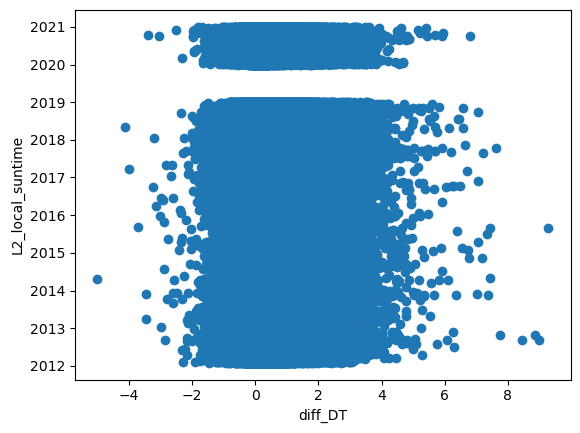

In [194]:
plt.scatter(table_all['diff_DT'], table_all['L2_local_suntime'])
plt.ylabel('L2_local_suntime')
plt.xlabel('diff_DT')

plt.show()